<a href="https://colab.research.google.com/github/huy20146177/baitapAI/blob/main/phan_loai_ca_chua_project_cuoi_ki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import listdir
from numpy import asarray
from numpy import save
from keras.utils.image_utils import img_to_array 
from keras.utils import load_img 
from numpy.lib.npyio import load
import numpy as np
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
 #Load data từ drive lên 
 folder='/content/drive/MyDrive/final_projectAi/Image/'
 #Tạo 2 danh sách trống để chứa ảnh và nhãn cần xử lí 
 photos,labels = list(),list()
 for file in listdir(folder):
  output=0.0    
  if file.startswith('ca_chua_chin'):
    output = 1.0
  if file.startswith('ca_chua_song'):
    output = 2.0    
  if file.startswith('ca_chua_hu'):
    output = 3.0      
  photo = load_img(folder+file, target_size= (128,128))
  for angle in range(20,81,60):
    for zoom in  range(-40,41,20):
      datagen = ImageDataGenerator(
          rotation_range= angle,  # Góc xoay
          horizontal_flip=True,  # Lật theo chiều ngang
          zoom_range=zoom/100,  # Tỷ lệ zoom
          width_shift_range=0.2,  # Dịch chuyển theo chiều ngang
          height_shift_range=0.2,  # Dịch chuyển theo chiều dọc
          brightness_range=[0.8,1.2]  # Độ sáng
      )
      # Thay đổi kích thước ảnh thành (1, height, width, channels)
      photo_np = np.expand_dims(photo, axis=0)
      # Tạo batch dữ liệu biến đổi từ ảnh gốc
      batch = datagen.flow(photo_np, batch_size=1)
      for i in range(6):
          augmented_image = next(batch)[0].astype('uint8')
          photos.append(augmented_image)
          labels.append(output)
  # photo = rgb2gray(photo)
  photo = img_to_array(photo)
  photos.append(photo)
  labels.append(output)
 photos= asarray(photos)
 labels = asarray(labels)
 # Lưu file hình và file nhãn vào drive để sau này xử lí  
 save('/content/drive/MyDrive/final_projectAi/photo_phat_hien_ca_chua.npy',photos)
 save('/content/drive/MyDrive/final_projectAi/label_phat_hien_ca_chua.npy',labels)

In [ ]:
#Tải ảnh và nhãn đã lưu lên để xử lí
photo = np.load('/content/drive/MyDrive/final_projectAi/photo_phat_hien_ca_chua.npy')
label = np.load('/content/drive/MyDrive/final_projectAi/label_phat_hien_ca_chua.npy')

In [ ]:
#Chia dữ liệu thành 2 phần train và test để kiểm tra mô hình
split_sample = int(0.2*len(photo))   # phần train : 80% , test: 20%
(x_train,y_train) = photo[split_sample:],label[split_sample:]
(x_test,y_test)= photo[:split_sample],label[:split_sample]

In [ ]:
#Kiểm tra kích thước của tập train
x_train.shape

(5564, 128, 128, 3)

In [ ]:
#Kiểm tra kích thước của tập test
x_test.shape

(1390, 128, 128, 3)

In [ ]:
#Đưa ảnh về độ phân giải 128x128 để đảm bảo độ chính xác 
# và giảm thiểu thời gian tính toán
x_train = x_train.reshape(5564,128,128,3)
x_test = x_test.reshape(1390,128,128,3)
#Chia 255 để chuẩn hóa dữ liệu về khoảng 0 đến 1 giúp 
# mô hình học được nhanh và hiệu quả hơn 
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# chuyển đổi các nhãn lớp của dữ liệu huấn luyện và 
# kiểm tra thành các vectơ one-hot encoding.
from keras.utils import to_categorical
y_train = to_categorical(y_train,4)
y_test  = to_categorical(y_test,4)

In [ ]:
# Khai báo các thư viện cần thiết để xây dựng mô hình CNN
from keras.models import Sequential , Model
from keras.layers import Dense , Flatten, Dropout, Conv2D, MaxPooling2D ,Normalization,Input
from keras.optimizers import Adam 

In [ ]:
# Định nghĩa các biến 
batch_size = 64  # số lượng học
epochs =  50    #số lần học
classes = 4   # Số lớp

In [ ]:
model=Sequential()    # Khởi tạo đối tượng để xây dựng mô hình CNN 
# Dùng mô hình CNN với 3 lớp tích chập để huấn luyện cho tập dữ liệu tiền giấy 
model.add(Conv2D(64,kernel_size=(3,3),activation ='linear',input_shape= (128,128,3),padding= 'same'))   
# 64:số lần tích chập, (3,3): kích thước bộ lọc , hàm kích hoạt là hàm tuyến tính 
# với đầu vào ảnh là 128x128 pixel và 3 kênh màu
from keras.layers import LeakyReLU
# Sử dụng hàm kích hoạt LeakyReLU cho đầu ra của lớp Conv2D.
model.add(LeakyReLU(alpha= 0.1))
#Lọc giá trị lớn hơn với kích thước 2x2 
model.add(MaxPooling2D((2,2), padding= 'same'))

model.add(Conv2D(64,(3,3), activation= 'linear', padding= 'same'))
model.add(LeakyReLU(alpha= 0.1))
model.add(MaxPooling2D((2,2), padding= 'same'))

model.add(Conv2D(128,(3,3), activation= 'linear', padding= 'same'))
model.add(LeakyReLU(alpha= 0.1))
model.add(MaxPooling2D((2,2), padding= 'same'))

from keras.backend import categorical_crossentropy
from keras.losses import categorical_crossentropy
model.add(Flatten())  #chuyển đổi đầu ra của các lớp tích chập 
                      #và lớp pooling thành một vector 1D 

model.add(Dense(2048,activation='linear'))   #Đi qua 2048 lớp
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1042,activation='linear'))   #Đi qua 1024 lớp
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128,activation='linear'))   #Đi qua 128 lớp
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [ ]:
photo = 0

In [ ]:
model.compile(loss= categorical_crossentropy,optimizer= Adam(),metrics=['accuracy'])
train = model.fit(x_train,y_train,batch_size= batch_size,epochs=epochs,verbose =1)      
# verbose=1,Hiển thị giá trị train, chỉ xuất hiện 1 lần rồi biến mất

Epoch 1/50
87/87 [==============================] - 27s 91ms/step - loss: 0.8817 - accuracy: 0.7629
Epoch 2/50
87/87 [==============================] - 6s 69ms/step - loss: 0.2173 - accuracy: 0.9112
Epoch 3/50
87/87 [==============================] - 6s 70ms/step - loss: 0.1825 - accuracy: 0.9274
Epoch 4/50
87/87 [==============================] - 6s 70ms/step - loss: 0.1416 - accuracy: 0.9416
Epoch 5/50
87/87 [==============================] - 6s 70ms/step - loss: 0.0827 - accuracy: 0.9693
Epoch 6/50
87/87 [==============================] - 6s 72ms/step - loss: 0.1120 - accuracy: 0.9590
Epoch 7/50
87/87 [==============================] - 6s 70ms/step - loss: 0.0976 - accuracy: 0.9641
Epoch 8/50
87/87 [==============================] - 6s 72ms/step - loss: 0.0664 - accuracy: 0.9745
Epoch 9/50
87/87 [==============================] - 6s 70ms/step - loss: 0.0433 - accuracy: 0.9858
Epoch 10/50
87/87 [==============================] - 6s 72ms/step - loss: 0.0433 - accuracy: 0.9844
Epoch 11

In [ ]:
#Lưu mô hình vừa được huấn luyện xuống drive 
model.save('/content/drive/MyDrive/final_projectAi/phat_hien_ca_chua.h5')

Test loss: 0.7874255180358887
Test accuracy; 0.9071942567825317


Text(0.5, 1.0, 'Test loss & Test Accuracy')

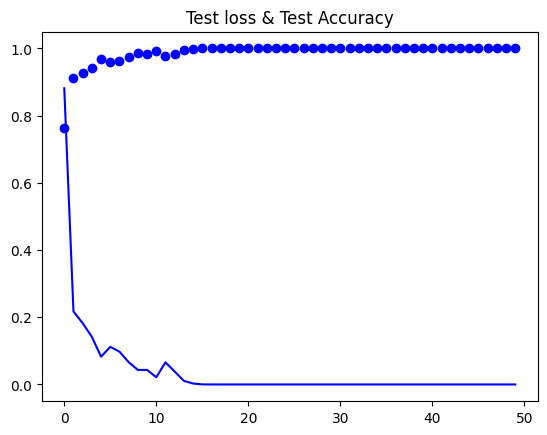

In [ ]:
# Vẽ đồ thị độ chính xác và  của tập test
import matplotlib.pyplot as plt
eval = model.evaluate(x_test,y_test,verbose=0)
print('Test loss:', eval[0])
print('Test accuracy;',eval[1])
accuracy = train.history['accuracy']
val_accuracy = train.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,'bo',label='Test loss')
plt.plot(epochs,val_accuracy,'b',label= 'Test Accuracy')
plt.title('Test loss & Test Accuracy')

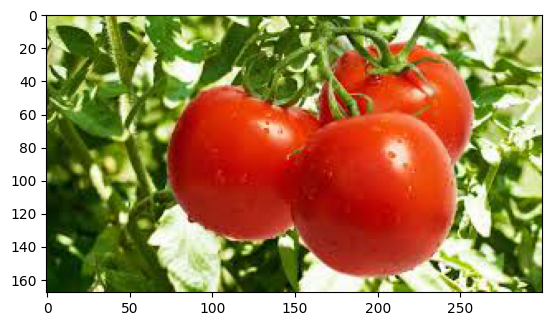

1/1 [==============================] - 0s 36ms/step
Hình ảnh là : cà chua chín


In [ ]:
import matplotlib.pyplot as plt
from keras.utils.image_utils import img_to_array 
from keras.utils import load_img 
import numpy as np

import matplotlib.pyplot as plt
from keras.utils.image_utils import img_to_array 
from keras.utils import load_img 
import numpy as np
# Tải một ảnh chưa train qua để kiểm tra độ chính xác của mô hình 
img1 = load_img('/content/drive/MyDrive/final_projectAi/image_test/3.jfif')
plt.imshow(img1)
plt.show()
img = load_img('/content/drive/MyDrive/final_projectAi/image_test/3.jfif',target_size=(128,128))
img= img_to_array(img)
img =img.reshape(1,128,128,3)
img = img.astype('float32')
img = img /255
ca_chua=np.argmax(model.predict(img),axis=-1)
if (ca_chua == 1) :
  print('Hình ảnh là : cà chua chín')
if (ca_chua == 2) :
  print('Hình ảnh là : cà chua sống ')
if (ca_chua == 3) :
  print('Hình ảnh là : cà chua hư')